# 毕设说明书
---

## 地图匹配，将充电需求对应在路网图中

1.将充电需求对应在路网图中，路网图为二维平面，充电需求由车辆产生，根据充电需求产生的地址将其对应到路网图中的点，所述点称为需求点。
所述需求点从城市中车辆停留时间较长的位置产生，包括以下信息：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程。

In [ ]:
'''
#1 —— 一次性执行
#t —— 测试单元，可删除
'''

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import truncnorm
import math
import pickle
import re
from random import choice
from utils import str_pi_format
from qga.q_pop import QuantumPopulation
from qga.question import Q1, Q1_1, DeJong, GoldStein
from concurrent.futures import ProcessPoolExecutor as Pool

In [2]:
# 
data_dir = 'data-QGA'

随机地图数据（包括地图块类型：小区、办公区、商贸区），地图设置为$1000\times1000$大小，其中住宅区占比：30%，办公区占比：10%,商贸区占比：5%

0-没有需求区域，1-小区，2-办公区，3-商贸区

In [3]:
# 常量定义
map_size = 100 #地图大小
map_step = 20  #划分地图

In [4]:
#1 使用随机直线划分格子
while True:
    map_roll = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
    map_cul = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
    if len(map_cul)==19 and len(map_roll)==19:
        break
print(map_roll.size)
print(map_cul.size)

19
19


In [5]:
#1 写入文件 
np.savetxt(data_dir+'/map_roll.txt', map_roll, fmt='%d', delimiter=',')
np.savetxt(data_dir+'/map_cul.txt', map_cul, fmt='%d', delimiter=',')

In [6]:
# 从文件中读取
map_roll = np.loadtxt(data_dir+'/map_roll.txt', delimiter=',', dtype=int)
map_roll = np.append(map_roll, map_size)
#map_roll = np.insert(map_roll, 0, 0)
map_cul = np.loadtxt(data_dir+'/map_cul.txt', delimiter=',', dtype=int)
#map_cul = np.insert(map_cul, 0, 0)
map_cul = np.append(map_cul, map_size)

In [7]:
#t
print(map_cul)

[  8  11  12  13  16  17  34  35  43  48  49  50  53  54  57  70  73  79
  98 100]


In [8]:
#1 随机区域
map_rate = [0.55, 0.3, 0.1, 0.05]
map_x = np.arange(4)
map_distribution = np.random.choice(a=map_x, size=map_step**2, replace=True, p=map_rate)

In [9]:
#1 将区域信息写入文件
np.savetxt(data_dir+'/map_distribution.txt', map_distribution, fmt='%d', delimiter=',')

In [10]:
# 读取区域
map_distribution = np.loadtxt(data_dir+'/map_distribution.txt', delimiter=',', dtype=int)

In [11]:
#t 看比例
print(sum(map_distribution==0)/map_step**2)
print(sum(map_distribution==1)/map_step**2)
print(sum(map_distribution==2)/map_step**2)
print(sum(map_distribution==3)/map_step**2)

0.5675
0.3
0.0675
0.065


In [12]:
#1 将地图赋值     

mmap = np.ones((map_size,map_size), dtype=np.int) #地图

x_b = 0
y_b = 0
it_mapd = 0
for y_e in map_cul:
    for x_e in map_roll:
        mmap[x_b:x_e, y_b:y_e] *= map_distribution[it_mapd]
        x_b = x_e
        it_mapd += 1
    y_b = y_e

In [13]:
#1 将地图存入文件
np.savetxt(data_dir+'/mmap.txt', mmap, fmt='%d', delimiter=',')

In [14]:
# 读取地图
mmap = np.loadtxt(data_dir+'/mmap.txt', delimiter=',', dtype=int)

In [15]:
#t 查看每种区域的地图占比
print(sum(sum(mmap==0))/map_size**2)
print(sum(sum(mmap==1))/map_size**2)
print(sum(sum(mmap==2))/map_size**2)
print(sum(sum(mmap==3))/map_size**2)

0.5445
0.3302
0.0567
0.0686


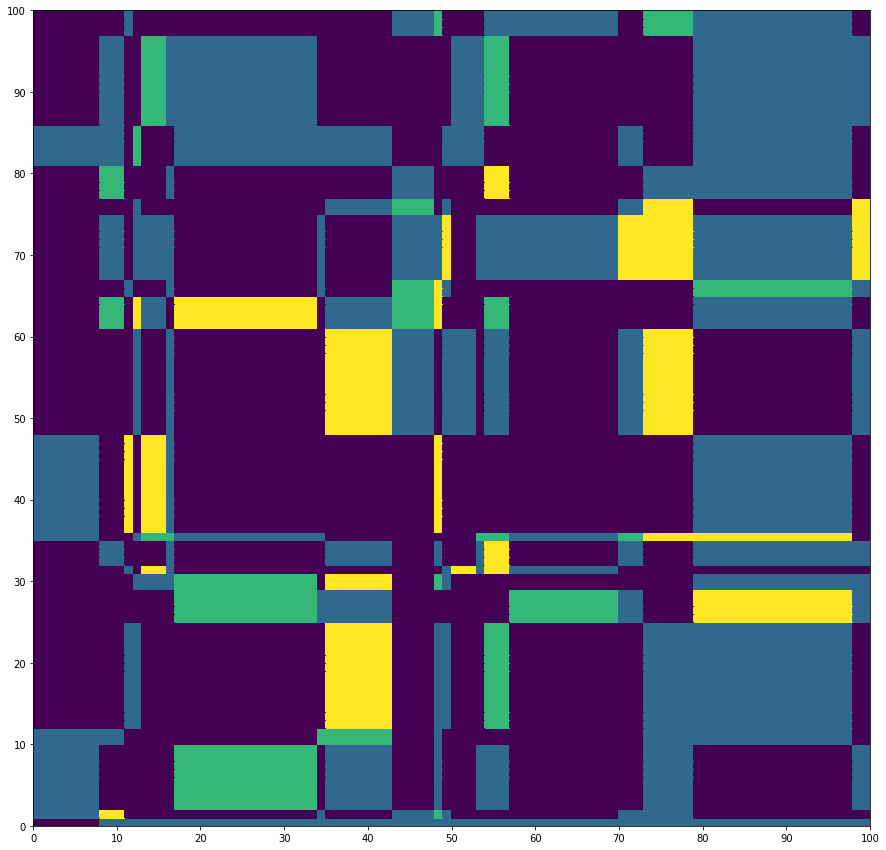

In [16]:
#t 将地图画出来
'''
0-其他区域-深深绿
1-住宅区-深绿
2-办公区-绿色
3-商贸区-黄色
'''
plt.figure(figsize=(15,15))
plt.pcolormesh(mmap,edgecolors='face')
#把x轴的刻度间隔设置为1，并存在变量里
x_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
y_major_locator=MultipleLocator(10)
#ax为两条坐标轴的实例
ax=plt.gca()
#把x轴的主刻度设置为50的倍数
ax.xaxis.set_major_locator(x_major_locator)
#把y轴的主刻度设置为50的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

随机车辆，地图类型对需求产生的时间要求：
1. 住宅区：车辆需求点产生时间多半在中午和夜晚，时间17:00-21:00~7:00-9:00和11:00-12:00~13:30-14:00
2. 办公区：车辆需求点产生时间多半在上午和下午，时间7:00-9:00~11:00-12:00和13:30-14:00~17:00-21:00
3. 商贸区：时间8:00~21:00，时间段多数在2小时以上
4. 其他区域：时间不固定

随机的变量：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程

随机车辆4000，其中2500遵循上班时间，1000遵循购物娱乐时间，500遵循在家时间

In [17]:
#1 随机时间
'''
car_cate
0-上班时间
时间：住宅区+办公区
地点：住宅+办公

1-娱乐时间
时间：住宅区+商贸区
地点：住宅+商贸

2-在家时间
时间：全天
地点：住宅
'''
#截断正态分布函数
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

car_num_0 = 2500
car_num_1 = 1000
car_num_2 = 500

# 上班时间
def cars_0():
    # 随机时间
    time_point_1_normal = get_truncated_normal(8.5, 1.5, 5, 10)
    time_point_1 = time_point_1_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_2_normal = get_truncated_normal(11.5, 0.5, 11, 12)
    time_point_2 = time_point_2_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_3_normal = get_truncated_normal(14, 0.5, 13, 15)
    time_point_3 = time_point_3_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_4_normal = get_truncated_normal(19, 1.5, 17, 21)
    time_point_4 = time_point_4_normal.rvs(car_num_0).reshape(car_num_0, 1)
    # 车辆id，为列向量
    car_id = np.arange(0,car_num_0).reshape(car_num_0, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_0, replace=True)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_2_index = np.random.choice(a=np.argwhere(mmap==2).shape[0], size=car_num_0, replace=True)#办公地址
    addr_2 = [np.argwhere(mmap==2)[i] for i in addr_2_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_0*4).reshape(car_num_0*4,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    
    car_id_con = np.concatenate((np.concatenate((car_id, car_id)), 
                                 np.concatenate((car_id, car_id))))
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), 
                                     np.concatenate((time_point_3, time_point_4))))
    addr_con = np.concatenate((np.concatenate((addr_2, addr_1)),
                               np.concatenate((addr_2, addr_1))))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_0_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_0_request = np.concatenate((car_0_request, remain_licheng), axis=1)
    # np.savetxt('data/car_0_request_test.txt', car_0_request, fmt='%f', delimiter=',')  
    df_car_0_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_0_request_read['充电需求产生的时间'] = time_point_con
    df_car_0_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request_read['预估充电时长'] = charge_time
    df_car_0_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_0_request_read.to_csv(data_dir+'/df_car_0_request_read.csv')
    
    df_car_0_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_0_request['time_point'] = time_point_con
    df_car_0_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request['charge_time'] = charge_time
    df_car_0_request['remain_licheng'] = remain_licheng
    df_car_0_request.to_csv(data_dir+'/df_car_0_request.csv')
    return df_car_0_request

# 娱乐时间
def cars_1():
    # 随机时间
    time_point_1_normal = get_truncated_normal(11, 1, 9, 13) # 去商场的时间点1
    time_point_1 = time_point_1_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_point_2_normal = get_truncated_normal(15, 2, 13, 19) # 去商场的时间点2
    time_point_2 = time_point_2_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_last_normal = get_truncated_normal(4, 1.5, 2, 11)
    time_last = time_last_normal.rvs(car_num_1).reshape(car_num_1, 1)
    time_point_temp = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_last), axis=1)
    time_point_3 = np.zeros((car_num_1, 1))  #回住宅的时间
    tp_i = 0
    for tpt in time_point_temp: # 24小时制
        time_p = tpt[0]+tpt[1]
        if time_p > 24:
            time_p -= 24
        time_point_3[tp_i] = time_p
        tp_i += 1
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_point_3))
    # 车辆id，为列向量
    car_id = np.arange(car_num_0, car_num_0+car_num_1).reshape(car_num_1, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_1, replace=False)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_3_index = np.random.choice(a=np.argwhere(mmap==3).shape[0], size=car_num_1, replace=True)#商贸地址
    addr_3 = [np.argwhere(mmap==3)[i] for i in addr_3_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_1*2).reshape(car_num_1*2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    car_id_con = np.concatenate((car_id, car_id))
    addr_con = np.concatenate((addr_3, addr_1))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_1_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_1_request = np.concatenate((car_1_request, remain_licheng), axis=1)
    # np.savetxt('data/car_1_request.txt', car_1_request, fmt='%f', delimiter=',')
    df_car_1_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_1_request_read['充电需求产生的时间'] = time_point_con
    df_car_1_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request_read['预估充电时长'] = charge_time
    df_car_1_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_1_request_read.to_csv(data_dir+'/df_car_1_request_read.csv')
    
    df_car_1_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_1_request['time_point'] = time_point_con
    df_car_1_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request['charge_time'] = charge_time
    df_car_1_request['remain_licheng'] = remain_licheng
    df_car_1_request.to_csv(data_dir+'/df_car_1_request.csv')
    return df_car_1_request


# 在家时间
def cars_2():
    # 随机时间
    time_point_normal = get_truncated_normal(12, 10, 0, 24)
    time_point = time_point_normal.rvs(car_num_2).reshape(car_num_2, 1)
    # 车辆id，为列向量
    car_id = np.arange(car_num_0+car_num_1,car_num_0+car_num_1+car_num_2).reshape(car_num_2, 1)
    # 随机地址
    addr_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_2, replace=True)#住宅地址
    addr = [np.argwhere(mmap==1)[i] for i in addr_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_2).reshape(car_num_2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    df_addr_con = pd.DataFrame(addr, columns = ['x','y'])
    df_car_2_request_read = pd.DataFrame(car_id, columns = ['车辆id'])
    df_car_2_request_read['充电需求产生的时间'] = time_point
    df_car_2_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request_read['预估充电时长'] = charge_time
    df_car_2_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_2_request_read.to_csv(data_dir+'/df_car_2_request_read.csv')
    
    df_car_2_request = pd.DataFrame(car_id, columns = ['car_id'])
    df_car_2_request['time_point'] = time_point
    df_car_2_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request['charge_time'] = charge_time
    df_car_2_request['remain_licheng'] = remain_licheng
    df_car_2_request.to_csv(data_dir+'/df_car_2_request.csv')
    return df_car_2_request

In [18]:
#1 写入文件
df_car_request = cars_0().append(cars_1()).append(cars_2())
df_car_request.to_csv(data_dir+'/df_car_request.csv')

In [3]:
# 读取充电需求数据
df_car_request = pd.read_csv(data_dir+'/df_car_request.csv', engine='python')
df_car_request.drop(df_car_request.columns[0], axis=1, inplace=True) # 删除第一列

## 预测城市充电需求，确定充电热区

该步骤是使用基于区域充电需求量的聚类算法实现的，具体步骤如下：
1. 数据清洗，由于会出现多个充电需求对应到同一需求点的情况，需要统计每个充电需求中预估的充电时长，之后计算每个需求点的总预估的充电时长作为该需求点的需求分数，公式如下：
$$SC_p=\sum_{i=1}^{n}ST_i$$
其中$SC_p$表示需求点$p$的需求分数，$ST_i$表示对应到需求点$p$的第$i$个充电需求中的预估充电时长
2. 删除需求分数过低的需求点，根据预先设置的阈值，删除需求分数低于阈值的需求点；
3. 使用K-means算法将需求点进行聚类，得到不同密度的簇，即充电热区，其代表着有一定充电需求的区域。

其中，步骤3中聚类个数K使用肘部法则来确定，将各个簇内的样本点到所在簇质心的距离平方和（SSE）作为性能度量，越小则说明各个类簇越收敛。但不是SSE越小越好，肘部法则就是在类簇数量与SSE之间寻求一个平衡点，具体步骤如下：

(1)指定一个i值，即可能的最大类簇数；

(2) 然后将类簇数从1开始递增，一直到$i$，计算出$i$个$SSE$，公式如下：
$$SSE=\sum_{k=1}^{k}\sum_{i\epsilon C_k}^{i}\lvert x_i-\mu k \rvert$$
其中，$\mu k$是第k个质心的位置

(3)通过画出K-SSE曲线，找出下降途中的拐点，即可较好的确定K值。

In [20]:
#1 1.数据清洗
def str_to_np(str_attr): #将字符串转换为numpy数组
    str_temp = str_attr[1:-1].strip().split(' ')
    if len(str_temp) > 2:
        str_temp[1] = str_temp[2]
        del str_temp[2]
    str_temp[0] = int(str_temp[0])
    str_temp[1] = int(str_temp[1])
    str_temp = np.asarray(str_temp)
    return str_temp

P_set = set(df_car_request['addr']) #需求点集合(dtype='object')
P_np = np.asarray([str_to_np(dfp) for dfp in P_set]) #需求点集合(dtype='np.array')
SCP_np = np.zeros(len(P_set)) # 需求点对应的需求分数
car_sum_np = np.zeros(len(P_set)) # 需求点对应的平均充电时间
it_scp = 0 #迭代数
for p in P_set: #计算需求分数
    it_df_p = df_car_request[df_car_request['addr'] == p]
    scp = it_df_p['charge_time'].sum()
    SCP_np[it_scp] = scp
    car_sum_np[it_scp] = len(it_df_p['charge_time'])
    it_scp += 1
    
df_p_np = pd.DataFrame(P_np, columns = ['x','y'])

df_scp = pd.DataFrame(df_p_np.apply(lambda r: tuple(r), axis=1).apply(np.array), columns=['addr'])
SCP_np.reshape(len(P_set), 1)
df_scp['scp'] = SCP_np
df_scp['car_sum'] = car_sum_np

# 2.删除需求分数过低的需求点（小于1的）
del_labels = np.where(SCP_np < 3)
del_labels = del_labels[0]
df_scp = df_scp.drop(del_labels)
# 将需求存入文件
df_scp.to_csv(data_dir+'/df_scp.csv') 

In [21]:
#t
print('需求分数小于1.5的占比：'+str(sum(SCP_np < 1.5)*100/len(SCP_np))+'%')
print('需求分数小于2.5的占比：'+str(sum(SCP_np < 2.5)*100/len(SCP_np))+'%')
print('需求分数小于3的占比：'+str(sum(SCP_np < 3)*100/len(SCP_np))+'%')
print('需求分数小于4的占比：'+str(sum(SCP_np < 4)*100/len(SCP_np))+'%')
print('需求分数小于5的占比：'+str(sum(SCP_np < 5)*100/len(SCP_np))+'%')

需求分数小于1.5的占比：11.912316123449669%
需求分数小于2.5的占比：28.872223824632247%
需求分数小于3的占比：37.00605710989328%
需求分数小于4的占比：52.61032593019902%
需求分数小于5的占比：62.070954715892704%


In [4]:
# 读取df_scp
def str_to_np(df_scp_0): #将df_scp中地址转换为numpy数组
    scp_0_array = np.zeros((len(df_scp_0), 2))
    it = 0
    for df_0 in df_scp_0:
        str_temp = df_0[1:-1].strip().split(' ')
        if len(str_temp) > 2:
            str_temp[1] = str_temp[2]
            del str_temp[2]
        str_temp[0] = int(str_temp[0])
        str_temp[1] = int(str_temp[1])
        scp_0_array[it] = [str_temp[0], str_temp[1]]
        it += 1
    return scp_0_array

df_scp = pd.read_csv(data_dir+'/df_scp.csv', engine='python')
df_scp.drop(df_scp.columns[0], axis=1, inplace=True) # 删除第一列
np_df_scp_addr = str_to_np(df_scp['addr']) # 需求点地址numpy数组
np_df_scp_scp = np.asarray(df_scp['scp']) # 需求点分数的numpy数组
np_df_scp_car_sum = np.asarray(df_scp['car_sum']) # 需求点车辆总数

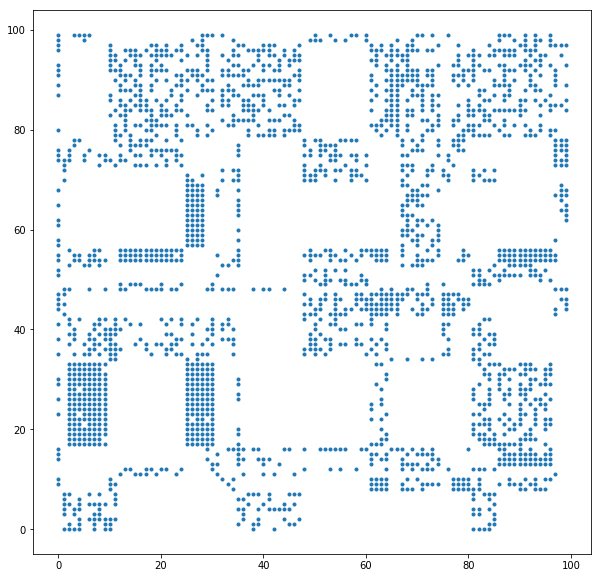

In [23]:
#t 需求点分布
plt.figure(figsize=(10,10))
plt.plot([x[0] for x in np_df_scp_addr], [x[1] for x in np_df_scp_addr], '.')
plt.show()

In [11]:
# 聚类定义
# np_df_scp_addr np_df_scp_scp

# 计算每个点到聚类中心的距离，并存入np_df_scp_centroids，即每个需求点对应的聚类中心
def assign(addr_attr, centroids):
    centroids_attr = np.zeros((len(addr_attr), 2))
    it_ndsc = 0
    for addr in addr_attr:
        distence = np.sqrt(np.sum(np.square(addr-centroids), axis=1))
        centroids_attr[it_ndsc] = centroids[np.argmin(distence)]
        it_ndsc += 1
    return centroids_attr


# 计算某聚类中心和所有需求点的距离之和
def cal_dis(addr_attr, centroid_attr):
    distence_1 = np.sum(np.sqrt(np.sum(np.square(addr_attr-centroid_attr), axis=1)))
    return distence_1
                            
# 聚类
def clustering(num_cluster):
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(np_df_scp_addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([np_df_scp_addr[i] for i in cluster_centroids_index])
    #print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 50:
        sse = 0
        np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids) # 计算每个点的聚类中心
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            # 取出属于同一聚类中心的点的索引
            index = []
            for i in range(len(np_df_scp_centroids)):
                if np_df_scp_centroids[i][0] == centroid[0] and np_df_scp_centroids[i][1] == centroid[1]:
                    index.append(i)
            addr_temp = np.zeros((len(index), 2))# 簇集合
            it_at = 0
            for i in index:
                addr_temp[it_at] = np_df_scp_addr[i]
                it_at += 1
            addr_temp = np.asarray(addr_temp)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    np.savetxt(data_dir+'/cluster_cen/cluster_centroids_'+str(num_cluster)+'.txt', cluster_centroids)
    return sse

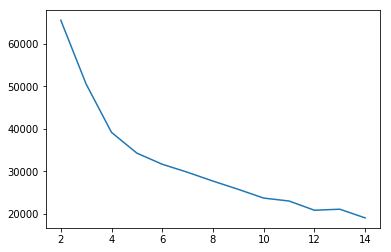

In [25]:
def sse():
    sse = []
    for k in range(2, 15):
        sse.append(clustering(k))
    return sse

x = np.arange(2, 15)

plt.plot(x, sse())
plt.show()

## 调整充电热区，确定充电站候选区域

总体方法为融合较小的簇、分割较大的簇，具体步骤如下：
1. 计算充电热区的半径和充电热区之间的距离矩阵；
2. 若某一充电热区和其他充电热区的距离小于r，则以半径r合并充电热区，其中r与电动汽车充满电的续航里程相关，r是为了保证电动汽车的剩余电量可以支撑其行驶到充电站，根据历史数据中电动汽车在该区域的平均剩余电量，可以利用现有方法估算行驶里程l，则$r=l$
3. 若充电热区的半径大于阈值r则在该热区内再次运行K-means算法划分新的充电热区，重复步骤1；
4. 得到充电站候选区域集合。

In [5]:
# 取出聚类中心
f_cluster_centroids = np.loadtxt(data_dir+'/cluster_cen/cluster_centroids_5.txt')
f_cluster_centroids

array([[20.37037037, 39.51010101],
       [77.8125    , 20.30803571],
       [52.41891892, 68.66409266],
       [85.61805556, 84.40972222],
       [13.43843844, 81.98798799]])

In [10]:
# 计算充电热区半径

# 计算距离 (多对一)
def cal_dis_2(addr_attr, centroid_attr):
    distence = np.sqrt(np.sum(np.square(addr_attr-centroid_attr), axis=1))
    return distence

# 计算充电热区之间的距离矩阵
def cal_dis_cen(centroids):
    dis = []
    for cen in centroids:
        distence = cal_dis_2(centroids, cen)
        distence.reshape(1, len(centroids))
        dis.append(distence)
    dis = np.asarray(dis)
    return dis

# 获得index (多对一)
# attr_1 : (,2)
# attr_2 : (1,2)
def equal_index(attr_1, attr_2):
    index = []
    for i in range(len(attr_1)):
        if attr_1[i][0] == attr_2[0] and attr_1[i][1] == attr_2[1]:
            index.append(i)
    return index

# 获得同一簇心的候选点
def get_addr(all_addr, centroids, centroid):
    np_df_scp_centroids_temp = assign(all_addr, centroids) # 将所有地址归类
    index = equal_index(np_df_scp_centroids_temp, centroid) # 取出属于centroid的需求点索引
    addr = np.zeros((len(index), 2))# 簇集合
    it_at = 0
    for i in index:
        addr[it_at] = all_addr[i]
        it_at += 1
    addr = np.asarray(addr)
    return addr

# 计算热区实际半径
def cal_real_r(addr_attr, centroids):
    real_radius = [] # 实际半径
    np_df_scp_centroids_temp = assign(addr_attr, centroids)# 将每个需求点归类
    for cen in centroids:
        addr = np.asarray([addr_attr[i] for i in equal_index(np_df_scp_centroids_temp, cen)])
        distence = np.sqrt(np.sum(np.square(addr-cen), axis=1))
        real_radius.append(np.amax(distence))
    real_radius = np.asarray(real_radius)
    return real_radius

# 计算热区应有半径
def cal_ideal_r(addr, centroids):
    ideal_r = []
    np_df_scp_centroids_temp = assign(addr, centroids)# 将每个需求点归类
    for centroid in centroids:
        index = equal_index(np_df_scp_centroids_temp, centroid) # 找出簇内候选点
        cars_num = sum([np_df_scp_car_sum[i] for i in index])
        scp = sum([np_df_scp_scp[i] for i in index])
        ideal_r.append(scp/cars_num*10)
    ideal_r = np.asarray(ideal_r)
    return ideal_r

# 聚类
def clustering_2(addr):
    num_cluster=2
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([addr[i] for i in cluster_centroids_index])
    # print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 20:
        sse = 0
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            addr_temp = get_addr(addr, cluster_centroids, centroid)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    #np.savetxt('data/cluster_cen_2/cluster_centroids_'+str(cluster)+'.txt', cluster_centroids)
    return cluster_centroids

In [28]:
#1 调整充电热区
# 判断是否达到条件
def is_qualified(ideal_r, real_r):
    '''
    for i in range(len(ideal_r)):
        if ideal_r[i] < real_r[i]:
            return True
    '''    
    return True

def ajust_cluster(addr_attr, centroids):
    dis_cen = cal_dis_cen(centroids)
    ideal_r = cal_ideal_r(addr_attr, centroids)
    real_r = cal_real_r(addr_attr, centroids)
    while True:
        new_centroids = np.zeros((len(centroids)*2, 2))
        for i in range(len(centroids)):
            i_r = ideal_r[i]
            r_r = real_r[i]
            d_c = dis_cen[i]
            if i_r < r_r:
                addr = get_addr(addr_attr, centroids, centroids[i])
                clu_temp = clustering_2(addr)
                new_centroids[i*2] = clu_temp[0]
                new_centroids[i*2+1] = clu_temp[1]
        centroids = np.asarray(new_centroids)
        print(centroids)
        dis_cen = cal_dis_cen(centroids)
        ideal_r = cal_ideal_r(addr_attr, centroids)
        real_r = cal_real_r(addr_attr, centroids)
        if is_qualified(ideal_r, real_r):
            np.savetxt(data_dir+'/cluster_centroids_temp.txt', centroids)
            return centroids
    



ajust_cluster(np_df_scp_addr, f_cluster_centroids)

[[83.81045752 49.79738562]
 [59.48214286 47.91517857]
 [11.19169329 34.19169329]
 [25.74090909 14.03636364]
 [69.71666667 11.54166667]
 [88.96276596 21.37765957]
 [89.14285714 85.74761905]
 [66.98190045 84.39366516]
 [29.9702381  88.10416667]
 [19.46231156 67.03517588]]


array([[83.81045752, 49.79738562],
       [59.48214286, 47.91517857],
       [11.19169329, 34.19169329],
       [25.74090909, 14.03636364],
       [69.71666667, 11.54166667],
       [88.96276596, 21.37765957],
       [89.14285714, 85.74761905],
       [66.98190045, 84.39366516],
       [29.9702381 , 88.10416667],
       [19.46231156, 67.03517588]])

## 确定充电站内的充电桩数量

1. 统计候选区域内候选点的停留时长及其时间段（每小时为1个时间段）；
2. 将停留时长除以3作为该候选点在其停留时间段的充电需求值； 
3. 统计候选区域内所有时间段的充电需求和，将其除以10作为候选区域的充电桩数量。

In [6]:
# 读取聚类中心
cluster_centroids_final = np.loadtxt(data_dir+'/cluster_centroids.txt')

In [30]:
#1 确定充电桩数量

def charging_pile_num(addr_attr, centroids, scp_attr):
    pile_num = []
    np_df_scp_centroids_temp = assign(addr_attr, centroids) # 将每个需求点归类
    for cen in centroids:
        index = equal_index(np_df_scp_centroids_temp, cen) # 取出索引
        # print(len(index))
        pile_num.append(sum([scp_attr[i] for i in index])/30)
    pile_num = np.asarray(pile_num)
    return pile_num

charging_p_n = charging_pile_num(np_df_scp_addr, cluster_centroids_final, np_df_scp_scp)
charging_p_n = np.ceil(charging_p_n)
np.savetxt(data_dir+'/charging_pile_num.txt', charging_p_n)

## 利用遗传算法实现最优布局

1. 创建初始种群，在遗传算法中，使用固定长度的二进制串来表示群体中的个体，将n个候选点编号为1-n，并根据是否设置充电站，将染色体上的基因进行编码，由{0，1}组成，0表示不设置充电站，1表示设置充电站；
2. 设置种群的个体适应度函数，个体适应度函数是布局目标的数学表达，考虑两个因素——用户和管理者因素，具体为用户的时间费用（平均行驶时间、充电排队时间）、管理者的建站费用（充电站的个数），公式如下：
$$S=\sum_{i\epsilon C}(\frac{\lambda_1}{num_j}\sum_{j\epsilon C_i}(t_{j1}+t_{j2})+\lambda_2\frac{1}{num_i})$$
其中，$C$表示充电站集合，表示第$i$个充电站，$j$表示选择作为充电目标的电动汽车，$t_{j1}$表示行驶时间，$t_{j2}$表示排队时间，$num_j$和$num_i$分别表示充电站的个数和选择此充电站的电动汽车个数，$\lambda_1$和$\lambda_2$代表用户时间费用和管理者建站费用的系数，通过实验得出，因此，布局目标是用户到达最近充电站的耗时和成电站个数最少。
3. 执行遗传算子不断迭代得到最终解；

In [12]:
# 随机数据
# 上面已经读取聚类中心cluster_centroids_final

np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids_final) # 将每个需求点归类

# 计算车辆数目
def car_num(i, centroids_attr):
    cen = centroids_attr[i]
    index = equal_index(np_df_scp_centroids, cen) # 取出索引
    car_num_attr = sum([np_df_scp_car_sum[j] for j in index])
    return car_num_attr

In [13]:
tj1 = np.random.randint(1, 200, 10)
tj2 = np.random.randint(1, 100, 10)
lamda_1 = np.random.randint(1, 100, 10)
lamda_2 = np.random.randint(1, 100, 10)

In [13]:
# 遗传算法

def run_QGA(s_step=0.025*np.pi):
    q_pop = QuantumPopulation(question=DeJong(), step=s_step)
    q_pop.init_population()             # 初始化种群
    q_pop.measure()                     # 初始观测
    q_pop.evaluate_population()         # 初始的适应度评估
    q_pop.show_population_infor()
    while q_pop.generation < q_pop.max_generation:
        q_pop.generation += 1
        print('-----------------------------------第{}代， 幅值{}------------------------------------------'.format(q_pop.generation, str_pi_format(s_step)))
        q_pop.update_quantum_population()       # 更新量子种群
        q_pop.measure()                         # 量子观测
        q_pop.evaluate_population()             # 评价该量子种群
        q_pop.show_population_infor()
    print('')
    print("最优适应度为：{}, 编码后的值为{}, 染色体表示为{}".format(q_pop.best_fitness, q_pop.best_solution,
                                                 q_pop.best_chrom))
    print('最先取得较优解的代数为', q_pop.first_better_fitness_generation)
    # q_pop.draw_pictual_2()
    print('**************************************************************************')
    return q_pop


def qga_debug():
    q1 = QuantumPopulation(Q1())
    q1.init_population()
    q1.measure()
    q1.evaluate_population()  # 初始的适应度评估
    q1.show_population_infor()


def run_many_times(step):
    times = 20
    avg_fitness_list = np.empty(times)                 # 进化到最后一代的平均适应度
    median_fitness_list = np.empty(times)              # 进化到最后一代的适应度中位数
    best_fitness_list = np.empty(times)                # 进化到最后一代的最优适应度
    global_best_fitness_list = np.empty(times)         # 进化到最后一代的全局最优解

    better_fitness_count_list = np.empty(times)         # 进化到最后一代的获得较优解次数
    first_better_fitness_generation_list = []           # 全局最先获得较优解的代数(有可能为None)

    best_fitness_in_many_times = None                   # 30代里面最好的解
    best_fitness_solution_in_many_times = None          # 30代里面最好解的xy解码值
    best_fitness_chrom_in_many_times = None             # 30代里面最好解的染色体编码

    for i in range(times):
        q_pop = run_QGA(s_step=step)

        avg_fitness_list[i] = q_pop.avg_fitness_of_each_generation[-1]
        median_fitness_list[i] = q_pop.median_fitness_of_each_generation[-1]
        best_fitness_list[i] = q_pop.best_fitness_of_each_generation[-1]

        global_best_fitness_list[i] = q_pop.best_fitness

        better_fitness_count_list[i] = q_pop.better_fitness_count_of_each_generation[-1]
        if q_pop.first_better_fitness_generation:
            first_better_fitness_generation_list.append(q_pop.first_better_fitness_generation)
        if not best_fitness_in_many_times or q_pop.best_fitness > best_fitness_in_many_times:
            best_fitness_in_many_times = q_pop.best_fitness
            best_fitness_solution_in_many_times = q_pop.best_solution
            best_fitness_chrom_in_many_times = str(q_pop.best_chrom)

    return str_pi_format(step), {
        "avg_fitness" : np.average(avg_fitness_list),
        "median_fitness" : np.average(median_fitness_list),
        "best_fitness": np.average(best_fitness_list),
        "global_best_fitness": np.average(global_best_fitness_list),

        "better_fitness_count" : np.average(better_fitness_count_list),
        "first_better_fitness_generation" : np.average(first_better_fitness_generation_list) if first_better_fitness_generation_list else -1,       # ************************

        "best_fitness_in_many_times" : best_fitness_in_many_times,
        "best_fitness_solution_in_many_times" : best_fitness_solution_in_many_times,
        "best_fitness_chrom_in_many_times" : best_fitness_chrom_in_many_times,
    }


def my_test_1():
    # step_list = np.pi * np.linspace(0.001, 0.5, 50)
    step_list = np.pi * np.linspace(0.001, 0.05, 30)

    pool = Pool(max_workers=3)
    infor_list = pool.map(run_many_times, step_list)     # 使用多进程改进

    # infor_list = [run_many_times(step) for step in step_list]

    infor_list = sorted(list(infor_list))
    print(infor_list)

    with open('mydata2.csv', 'w') as f:
        f.write('{},{},{},{},{},{},{},{},{},{},{}\n'.format(
            'theta', 'avg', 'median', 'best', 'global_best',
            'better_count', 'first_better_generation',
            'best_in_many_times', 'best_x_in_many_times', 'best_y_in_many_times',
            'best_chrom_in_many_times'
        ))

    for s, d in infor_list:
        for k,v in d.items():
            print(k, v)
        with open('mydata2.csv', 'a') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{}\n".format(
                s.replace('pi', ''), d['avg_fitness'], d['median_fitness'], d['best_fitness'], d['global_best_fitness'],
                d['better_fitness_count'], d['first_better_fitness_generation'],
                d['best_fitness_in_many_times'], d['best_fitness_solution_in_many_times'][0], d['best_fitness_solution_in_many_times'][1],
                d['best_fitness_chrom_in_many_times']
            ))

当前代数为：0，在种群位置为:5, 找到一个更好的解：-0.2754188495999996啦，它的经典染色体组成：[1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1]，解码后的值为(0.694, 0.439)，
量子种群
 [[[0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678]]

 [[0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678
   0.70710678 0.70710678 0.70710678 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.7071

   0.00999495  0.         -0.00999495  0.00999495  0.          0.        ]]
量子种群
 [[[0.65 0.75 0.64 0.75 0.67 0.75 0.64 0.62 0.75 0.69 0.62 0.79 0.67 0.81
   0.75 0.62 0.69 0.77 0.67 0.67 0.79 0.69 0.63 0.67]
  [0.77 0.67 0.77 0.66 0.75 0.66 0.77 0.79 0.67 0.73 0.79 0.63 0.75 0.59
   0.67 0.79 0.73 0.64 0.75 0.75 0.62 0.73 0.79 0.75]]

 [[0.64 0.81 0.67 0.77 0.66 0.77 0.66 0.65 0.77 0.64 0.67 0.81 0.62 0.79
   0.75 0.66 0.64 0.77 0.65 0.59 0.79 0.67 0.69 0.67]
  [0.77 0.59 0.75 0.64 0.75 0.64 0.75 0.77 0.64 0.77 0.75 0.59 0.79 0.63
   0.67 0.75 0.77 0.64 0.77 0.81 0.62 0.75 0.73 0.75]]

 [[0.67 0.77 0.6  0.75 0.67 0.75 0.66 0.67 0.75 0.62 0.66 0.81 0.67 0.73
   0.77 0.65 0.67 0.79 0.65 0.65 0.79 0.65 0.6  0.67]
  [0.75 0.64 0.81 0.66 0.75 0.67 0.75 0.75 0.67 0.79 0.75 0.6  0.75 0.69
   0.65 0.77 0.75 0.63 0.77 0.77 0.62 0.77 0.81 0.75]]

 [[0.63 0.75 0.69 0.77 0.63 0.77 0.67 0.69 0.79 0.6  0.63 0.77 0.65 0.75
   0.75 0.63 0.69 0.75 0.63 0.67 0.79 0.63 0.65 0.67]
  [0.79 0.67 0.73 0.65 

更新角度策略： [[ 0.         -0.00999105  0.00999105  0.          0.          0.
   0.          0.00999105  0.00999105  0.          0.          0.
   0.          0.          0.          0.          0.00999105 -0.00999105
  -0.00999105  0.          0.          0.          0.00999105  0.00999105]
 [ 0.00993393  0.          0.          0.         -0.00993393  0.00993393
   0.          0.00993393  0.         -0.00993393  0.          0.
   0.          0.         -0.00993393  0.00993393  0.         -0.00993393
  -0.00993393 -0.00993393  0.          0.          0.00993393  0.        ]
 [ 0.         -0.00999176  0.00999176  0.          0.          0.
   0.00999176  0.          0.00999176  0.          0.00999176  0.
   0.          0.          0.          0.          0.00999176  0.
   0.         -0.00999176  0.          0.          0.          0.00999176]
 [ 0.00998749  0.          0.          0.          0.          0.
   0.          0.00998749  0.00998749 -0.00998749  0.00998749  0.
   0.00998749  0.

更新角度策略： [[ 0.00994913  0.          0.          0.          0.          0.
   0.          0.          0.00994913 -0.00994913  0.          0.
   0.          0.          0.          0.00994913  0.00994913  0.
  -0.00994913 -0.00994913  0.          0.          0.          0.        ]
 [ 0.         -0.00999826  0.00999826  0.         -0.00999826  0.
   0.          0.          0.00999826  0.          0.          0.
   0.00999826  0.          0.          0.          0.          0.
  -0.00999826 -0.00999826 -0.00999826  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.00997334  0.          0.         -0.00997334
   0.          0.         -0.00997334  0.          0.          0.
   0.         -0.00997334  0.          0.00997334  0.          0.        ]
 [ 0.         -0.00999836  0.00999836 -0.00999836  0.          0.
   0.          0.          0.         -0.00999836  0.          0.
   0.00999836  0.          0.    

   0.          0.         -0.00994095  0.00994095  0.          0.00994095]]
量子种群
 [[[0.42 0.87 0.38 0.85 0.81 0.61 0.47 0.47 0.6  0.81 0.44 0.89 0.54 0.9
   0.87 0.48 0.48 0.9  0.79 0.75 0.85 0.6  0.52 0.45]
  [0.91 0.51 0.92 0.54 0.6  0.8  0.89 0.89 0.81 0.6  0.9  0.49 0.85 0.44
   0.51 0.89 0.89 0.44 0.63 0.67 0.53 0.81 0.87 0.9 ]]

 [[0.5  0.9  0.51 0.87 0.74 0.67 0.53 0.46 0.65 0.76 0.51 0.91 0.47 0.87
   0.9  0.5  0.48 0.89 0.79 0.76 0.9  0.48 0.48 0.48]
  [0.87 0.44 0.87 0.5  0.67 0.74 0.85 0.9  0.76 0.65 0.87 0.41 0.89 0.51
   0.45 0.87 0.89 0.48 0.63 0.65 0.45 0.89 0.88 0.89]]

 [[0.6  0.87 0.48 0.79 0.77 0.67 0.47 0.45 0.61 0.76 0.57 0.9  0.48 0.83
   0.85 0.51 0.55 0.85 0.75 0.81 0.87 0.48 0.42 0.48]
  [0.81 0.5  0.89 0.62 0.65 0.75 0.89 0.9  0.81 0.65 0.83 0.45 0.89 0.57
   0.54 0.87 0.85 0.54 0.67 0.61 0.5  0.89 0.91 0.89]]

 [[0.51 0.85 0.54 0.88 0.75 0.63 0.52 0.54 0.66 0.79 0.54 0.87 0.42 0.85
   0.88 0.55 0.54 0.85 0.77 0.79 0.84 0.46 0.4  0.46]
  [0.87 0.54 0.85 0.49 0

更新角度策略： [[ 0.00975913  0.          0.          0.          0.          0.
   0.          0.          0.00975913  0.          0.          0.
   0.          0.          0.          0.          0.         -0.00975913
   0.          0.          0.          0.          0.          0.00975913]
 [ 0.          0.          0.          0.          0.          0.00930369
   0.00930369  0.          0.00930369 -0.00930369  0.          0.
   0.          0.          0.          0.00930369  0.         -0.00930369
   0.          0.          0.          0.00930369  0.          0.00930369]
 [ 0.         -0.00999945  0.         -0.00999945  0.          0.00999945
   0.00999945  0.00999945  0.          0.          0.          0.
   0.00999945  0.          0.          0.          0.          0.
   0.          0.         -0.00999945  0.00999945  0.00999945  0.        ]
 [ 0.          0.          0.0099907   0.         -0.0099907   0.
   0.0099907   0.          0.         -0.0099907   0.0099907   0.
   0.    

更新角度策略： [[ 0.         -0.00999927  0.          0.         -0.00999927  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00999927  0.          0.
   0.          0.00999927 -0.00999927  0.          0.          0.00999927]
 [ 0.          0.          0.00991648 -0.00991648  0.          0.
   0.00991648  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00991648 -0.00991648  0.          0.          0.00991648]
 [ 0.          0.          0.00995711  0.          0.          0.00995711
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00995711  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.0099943   0.0099943   0.          0.0099943   0.
   0.         -0.0099943   0.    

更新角度策略： [[ 0.          0.          0.          0.00999925  0.00999925 -0.00999925
   0.          0.          0.00999925  0.         -0.00999925 -0.00999925
   0.          0.          0.          0.          0.          0.
   0.         -0.00999925  0.          0.          0.00999925 -0.00999925]
 [ 0.          0.          0.          0.          0.         -0.00999864
   0.          0.          0.         -0.00999864 -0.00999864  0.
   0.         -0.00999864  0.00999864  0.          0.          0.
   0.         -0.00999864 -0.00999864  0.00999864  0.         -0.00999864]
 [ 0.00999961  0.          0.          0.00999961  0.         -0.00999961
   0.          0.00999961  0.          0.         -0.00999961  0.
   0.00999961  0.          0.00999961  0.00999961  0.          0.
   0.         -0.00999961  0.          0.          0.         -0.00999961]
 [ 0.          0.          0.          0.          0.00999948 -0.00999948
   0.          0.          0.          0.         -0.00999948  0.
 

更新角度策略： [[ 0.         -0.00999999  0.          0.00999999  0.          0.
   0.          0.          0.         -0.00999999  0.00999999  0.
   0.          0.          0.00999999  0.00999999  0.00999999  0.00999999
   0.00999999  0.          0.          0.00999999  0.          0.        ]
 [ 0.          0.          0.          0.00999664  0.          0.00999664
   0.          0.00999664 -0.00999664  0.          0.          0.
   0.          0.          0.          0.00999664  0.          0.00999664
   0.00999664  0.          0.          0.          0.          0.        ]
 [ 0.00999992  0.          0.          0.00999992  0.          0.
   0.00999992  0.          0.          0.          0.          0.
   0.00999992  0.          0.          0.          0.00999992  0.00999992
   0.00999992  0.          0.          0.          0.          0.        ]
 [ 0.         -0.00999997  0.          0.00999997  0.00999997  0.00999997
   0.          0.00999997 -0.00999997  0.          0.00999997  0.
 

更新角度策略： [[ 0.          0.          0.          0.          0.          0.00999959
   0.00999959  0.         -0.00999959  0.          0.          0.
   0.          0.          0.00999959  0.          0.00999959  0.00999959
   0.00999959  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.00999968  0.          0.          0.
   0.          0.          0.00999968  0.          0.          0.00999968
   0.00999968  0.00999968  0.          0.00999968  0.00999968  0.        ]
 [ 0.          0.          0.          0.          0.0099953   0.
   0.          0.0099953   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.0099953
   0.0099953   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.00999956  0.          0.
   0.          0.         -0.00999956  0.          0.00999956 -0.00999956
  

更新角度策略： [[ 0.00999947  0.          0.          0.00999947  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.00999945  0.00999945  0.00999945 -0.00999945
   0.          0.          0.         -0.00999945  0.          0.
   0.          0.          0.00999945  0.          0.         -0.00999945
   0.          0.          0.00999945  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00999885  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.00999885
   0.         -0.00999885  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.00999772  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.

更新角度策略： [[ 0.          0.          0.          0.00999975  0.00999975  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.00999975
   0.         -0.00999975  0.00999975  0.          0.          0.        ]
 [ 0.          0.          0.          0.0099997   0.0099997   0.
   0.          0.          0.0099997   0.          0.0099997   0.
   0.          0.          0.          0.          0.          0.
   0.         -0.0099997   0.0099997   0.          0.          0.        ]
 [ 0.          0.          0.          0.0099985   0.0099985  -0.0099985
   0.          0.          0.          0.          0.          0.
   0.          0.          0.0099985   0.0099985   0.          0.
   0.          0.          0.0099985   0.          0.          0.0099985 ]
 [ 0.          0.          0.          0.00999986  0.          0.
   0.          0.          0.          0.          0.          0.
   0.00999986  0.         

更新角度策略： [[ 0.          0.          0.          0.          0.00999811  0.
   0.          0.          0.          0.          0.00999811  0.
   0.          0.          0.          0.          0.          0.
   0.         -0.00999811  0.00999811  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.00999951  0.          0.         -0.00999951
   0.          0.          0.00999951  0.          0.          0.
  -0.00999951  0.          0.00999951  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.00999977  0.          0.         -0.00999977
   0.          0.          0.00999977  0.          0.         -0.00999977
   0.          0.

更新角度策略： [[ 0.          0.          0.          0.00999969  0.00999969  0.
   0.          0.00999969  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.00999969  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.00890386  0.00890386  0.          0.          0.        ]
 [ 0.00999976  0.          0.00999976  0.          0.         -0.00999976
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.00999976  0.00999976  0.          0.          0.00999976]
 [ 0.          0.          0.          0.          0.         -0.00998151
   0.          0.00998151  0.00998151  0.          0.          0.
   0.          0.        

更新角度策略： [[ 0.          0.          0.          0.          0.         -0.00562571
   0.          0.00562571  0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.00562571
  -0.00562571  0.          0.00562571  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.00999401
   0.          0.          0.          0.          0.         -0.00999401
   0.          0.          0.          0.          0.          0.
   0.          0.          0.00999401  0.          0.          0.        ]
 [ 0.         -0.00999998  0.          0.          0.00999998 -0.00999998
   0.          0.          0.00999998  0.          0.          0.
   0.         -0.00999998  0.00999998  0.          0.         -0.00999998
   0.          0.          0.00999998  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.007567

   0.         -0.00999932  0.          0.          0.         -0.00999932]]
量子种群
 [[[0.24 0.92 0.23 0.39 0.36 0.84 0.24 0.24 0.42 0.96 0.24 0.98 0.27 0.96
   0.45 0.3  0.24 0.93 0.92 0.89 0.49 0.29 0.23 0.4 ]
  [0.97 0.39 0.97 0.92 0.93 0.55 0.97 0.96 0.9  0.27 0.97 0.22 0.96 0.26
   0.9  0.95 0.97 0.36 0.44 0.48 0.88 0.95 0.98 0.92]]

 [[0.26 0.96 0.24 0.43 0.38 0.88 0.23 0.25 0.38 0.95 0.3  0.96 0.26 0.98
   0.48 0.26 0.27 0.91 0.92 0.92 0.57 0.18 0.33 0.41]
  [0.96 0.26 0.97 0.9  0.92 0.5  0.96 0.97 0.93 0.31 0.95 0.26 0.96 0.21
   0.89 0.96 0.96 0.42 0.37 0.39 0.83 1.   0.93 0.91]]

 [[0.27 0.95 0.27 0.37 0.45 0.89 0.23 0.27 0.38 0.93 0.32 0.95 0.24 0.97
   0.48 0.21 0.16 0.93 0.89 0.92 0.52 0.27 0.18 0.39]
  [0.96 0.29 0.96 0.92 0.9  0.46 0.97 0.96 0.94 0.34 0.95 0.3  0.97 0.24
   0.89 0.98 1.   0.37 0.48 0.44 0.86 0.96 0.99 0.92]]

 [[0.18 0.95 0.24 0.38 0.4  0.86 0.19 0.24 0.39 0.95 0.28 0.97 0.24 0.96
   0.47 0.31 0.3  0.92 0.9  0.92 0.62 0.22 0.16 0.53]
  [0.99 0.3  0.97 0.92 

量子种群
 [[[0.24 0.93 0.23 0.36 0.36 0.88 0.21 0.24 0.33 0.97 0.24 0.98 0.27 0.96
   0.39 0.27 0.24 0.93 0.92 0.91 0.46 0.29 0.2  0.53]
  [0.97 0.36 0.97 0.93 0.93 0.49 0.98 0.96 0.93 0.24 0.97 0.22 0.96 0.26
   0.92 0.96 0.97 0.36 0.44 0.42 0.89 0.95 0.99 0.86]]

 [[0.23 0.96 0.24 0.4  0.35 0.9  0.23 0.25 0.32 0.95 0.3  0.96 0.26 0.98
   0.45 0.26 0.27 0.92 0.94 0.94 0.57 0.15 0.33 0.54]
  [0.97 0.26 0.97 0.91 0.93 0.47 0.96 0.97 0.95 0.31 0.95 0.24 0.96 0.21
   0.9  0.96 0.96 0.39 0.31 0.33 0.83 1.01 0.93 0.84]]

 [[0.27 0.95 0.27 0.34 0.39 0.9  0.23 0.27 0.35 0.94 0.32 0.95 0.24 0.97
   0.45 0.21 0.16 0.94 0.91 0.93 0.49 0.27 0.15 0.51]
  [0.96 0.29 0.96 0.93 0.92 0.43 0.97 0.96 0.95 0.32 0.95 0.3  0.97 0.24
   0.9  0.98 1.   0.34 0.42 0.41 0.88 0.96 1.   0.86]]

 [[0.18 0.95 0.24 0.35 0.34 0.86 0.13 0.21 0.39 0.95 0.28 0.97 0.21 0.96
   0.35 0.31 0.3  0.94 0.92 0.92 0.53 0.22 0.16 0.64]
  [0.99 0.3  0.97 0.93 0.94 0.51 0.99 0.98 0.92 0.27 0.96 0.25 0.98 0.27
   0.93 0.95 0.95 0.33 0.3

更新角度策略： [[ 0.          0.          0.          0.          0.          0.
   0.          0.00999784  0.          0.          0.00999784  0.
   0.          0.          0.          0.00999784  0.          0.
   0.          0.          0.          0.          0.         -0.00999784]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.00999939  0.          0.         -0.00999939
  -0.00999939  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.00990398  0.          0.          0.          0.         -0.00990398]
 [ 0.          0.          0.          0.00999954  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.    

更新角度策略： [[ 0.         -0.01        0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.01        0.          0.          0.          0.          0.
  -0.01        0.          0.          0.          0.         -0.01      ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.00999997  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.00999997]
 [ 0.         -0.00999999  0.          0.          0.          0.
   0.00999999  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.0099999   0.          0.

更新角度策略： [[ 0.          0.          0.          0.00998312  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.00998312  0.          0.          0.
   0.         -0.00998312  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.0099994   0.          0.
   0.          0.          0.         -0.0099994   0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.0099994 ]
 [ 0.          0.          0.          0.          0.         -0.00999377
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00999377  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.00565238
   0.          0.        

当前代数的中位适应度 -0.291957857599999
当前代数的最优适应度 -0.002117345600000001
当前代数的适应度方差 9734.083926777037
当前代数的适应度标准差 98.66146120333428
当前代数取得较优解的次数6.0，总共有15个解(种群数量)
-----------------------------------第117代， 幅值0.025pi------------------------------------------
更新角度策略： [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -0.00989798  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.00999941  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.00996374  0.          0.         -0.00996374  0.          0.
   0.          0.          0.          0.          0.          0.
  

更新角度策略： [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00563208  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00563208 -0.00563208  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00877004 -0.00877004  0.          0.          0.00877004]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00563208  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00563208 -0.00563208  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00999083  0.
   0.          0.          0.          0.00999083  0.          0.
   0.          0.          0.          0.

更新角度策略： [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00848815 -0.00848815  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00866515  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00866515  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.00906902  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.00999997
   0.          0.          0.          0.00999997  0.          0.
   0.00999997  0.          0.    

更新角度策略： [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00563208  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00563208 -0.00563208  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00606423  0.         -0.00606423
   0.          0.          0.          0.          0.          0.
   0.          0.00606423 -0.00606423  0.          0.          0.00606423]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00563208  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.00563208 -0.00563208  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00999807  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.    

更新角度策略： [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00787462  0.00787462  0.
   0.          0.          0.          0.          0.          0.
   0.          0.00787462 -0.00787462  0.          0.          0.        ]
 [ 0.         -0.00999999  0.          0.          0.          0.
   0.          0.00999999  0.          0.00999999  0.          0.
   0.          0.          0.00999999  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.00999997  0.          0.          0.
   0.00999997  0.          0.          0.

更新角度策略： [[ 0.         -0.00999999  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.00999999
   0.          0.          0.          0.          0.          0.
   0.          0.         -0.00999999  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.00967548
   0.          0.          0.          0.          0.          0.
   0.          0.00967548  0.          0.          0.          0.00967548]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.00967548
   0.          0.          0.          0.          0.          0.
   0.          0.00967548  0.          0.          0.          0.00967548]
 [ 0.         -0.00999999  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.00999999
   0.    

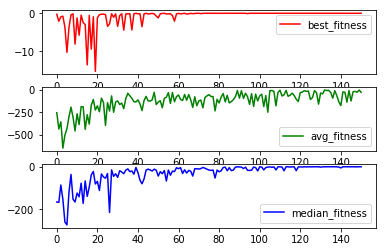

In [16]:
c = True
while c:
    a = run_QGA()
    if a.first_better_fitness_generation:
        c = False
        a.draw_pictual_2()